In [1]:
import os
import sys
import pathlib
import pickle as pkl
import json
import itertools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from arch import backbones, heads, models

from tqdm import tqdm

import utils.time
import utils.dict

from time import time
from datetime import datetime

import pprint

In [2]:
def load_json_dict(
        json_filename
        ):

    with open(json_filename, 'r') as json_file:
        json_dict = json.load(json_file)

    return json_dict

---

In [3]:
exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train")

backbones = ["resnet_50", "convnext_t"]
num_exps_list = [9, 13]

df_records = []

for backbone, num_exps in zip(backbones, num_exps_list):
    for exp_idx in range(num_exps):

        eval_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "eval_ctsrbm_data.json")
        if not os.path.exists(eval_filename):
            eval_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "eval_ctsrbm_metrics__data.json")
        eval_data = load_json_dict(eval_filename)

        exp_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "exp_data.json")
        exp_data = load_json_dict(exp_filename)

        df_record = {}

        # exp_data

        df_record["backbone"] = exp_data["settings"]["backbone"]["class"]
        df_record["experiment_name"] = "test_{:03d}".format(exp_idx)

        stage_1_batch_size = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
        stage_2_batch_size = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]

        stage_1_max_acc_iter = utils.dict.chain_get(
            exp_data,
            "settings", "stage_1", "max_acc_iter",
            default=1
        )
        stage_2_max_acc_iter = utils.dict.chain_get(
            exp_data,
            "settings", "stage_2", "max_acc_iter",
            default=1
        )

        df_record["loading_batch_size"] = stage_1_batch_size * stage_1_max_acc_iter

        df_record["stage_1_grad_acc_iters"] = stage_1_max_acc_iter
        df_record["stage_2_grad_acc_iters"] = stage_2_max_acc_iter

        df_record["stage_1_lr"] = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
        df_record["stage_2_lr"] = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

        df_record["num_gpus"] = len(exp_data["settings"]["gpu_usage"])
        
        # eval_data

        splits = ["test", "train", "val"]
        metrics = ["p", "r", "f1"]

        for split, metric in itertools.product(splits, metrics):

            value_key = "avg_{:s}_at_k_dict".format(metric)
            value_dict = eval_data["results"][split][value_key]

            for key, item in value_dict.items():

                column_name = "avg_{:s}_{:s}_at_{:s}".format(split, metric, key)
                df_record[column_name] = item

        df_records.append(df_record)
        

In [4]:
df = pd.DataFrame.from_records(df_records)

In [5]:
df

,backbone,experiment_name,loading_batch_size,stage_1_grad_acc_iters,stage_2_grad_acc_iters,stage_1_lr,stage_2_lr,num_gpus,avg_test_p_at_same,avg_test_p_at_all,...,avg_val_r_at_1,avg_val_r_at_3,avg_val_r_at_5,avg_val_r_at_10,avg_val_f1_at_same,avg_val_f1_at_all,avg_val_f1_at_1,avg_val_f1_at_3,avg_val_f1_at_5,avg_val_f1_at_10
0,ResNet50Backbone,test_000,32,1,1,0.00100,0.000500,6,0.046072,0.000146,...,0.039910,0.067998,0.084323,0.113005,0.046691,0.00029,0.045663,0.042728,0.036646,0.027729
1,ResNet50Backbone,test_001,32,1,1,0.00010,0.000050,6,0.042828,0.000146,...,0.038027,0.062477,0.077029,0.103989,0.043812,0.00029,0.043644,0.039325,0.033513,0.025510
2,ResNet50Backbone,test_002,32,1,1,0.00001,0.000005,6,0.042583,0.000146,...,0.036407,0.059807,0.073684,0.095596,0.041995,0.00029,0.042044,0.037917,0.032348,0.023750
3,ResNet50Backbone,test_003,16,1,1,0.00100,0.000500,6,0.049786,0.000146,...,0.043930,0.073982,0.092052,0.121667,0.050825,0.00029,0.050511,0.046571,0.040017,0.029947
4,ResNet50Backbone,test_004,16,1,1,0.00010,0.000050,6,0.044655,0.000146,...,0.037839,0.063607,0.079481,0.105745,0.043850,0.00029,0.043408,0.039929,0.034557,0.026099
5,ResNet50Backbone,test_005,16,1,1,0.00001,0.000005,6,0.045131,0.000146,...,0.039300,0.064534,0.078485,0.102327,0.045173,0.00029,0.045201,0.040745,0.034281,0.025396
6,ResNet50Backbone,test_006,8,1,1,0.00100,0.000500,6,0.058552,0.000146,...,0.051040,0.086256,0.106212,0.138329,0.059780,0.00029,0.058389,0.054299,0.046217,0.034154
7,ResNet50Backbone,test_007,8,1,1,0.00010,0.000050,6,0.045425,0.000146,...,0.039563,0.065861,0.082431,0.112440,0.045212,0.00029,0.045412,0.041337,0.035780,0.027680
8,ResNet50Backbone,test_008,8,1,1,0.00001,0.000005,6,0.047449,0.000146,...,0.041417,0.068631,0.084711,0.111069,0.047413,0.00029,0.047651,0.043298,0.036915,0.027433
9,ConvNeXtTinyBackbone,test_000,16,1,1,0.00100,0.000010,4,0.072864,0.000146,...,0.065155,0.110463,0.139527,0.185281,0.075676,0.00029,0.074283,0.069067,0.060371,0.045433


In [6]:
df_2 = df.copy()

metric_name = "avg_test_p_at_3"

df_2 = df_2.sort_values(metric_name, ascending=False)
df_2 = df_2[[
    "backbone",
    "loading_batch_size",
    "stage_1_grad_acc_iters",
    "stage_2_grad_acc_iters",
    "stage_1_lr",
    "stage_2_lr",
    "num_gpus",
    metric_name
]]

df_2

,backbone,loading_batch_size,stage_1_grad_acc_iters,stage_2_grad_acc_iters,stage_1_lr,stage_2_lr,num_gpus,avg_test_p_at_3
11,ConvNeXtTinyBackbone,16,1,1,0.01000,0.000010,4,0.054799
15,ConvNeXtTinyBackbone,32,1,1,0.01000,0.000010,4,0.051995
9,ConvNeXtTinyBackbone,16,1,1,0.00100,0.000010,4,0.051166
21,ConvNeXtTinyBackbone,16,1,2,0.00100,0.000010,8,0.050175
19,ConvNeXtTinyBackbone,64,1,2,0.01000,0.000010,4,0.048067
12,ConvNeXtTinyBackbone,16,1,1,0.01000,0.000001,4,0.047512
13,ConvNeXtTinyBackbone,32,1,1,0.00100,0.000010,4,0.047280
16,ConvNeXtTinyBackbone,32,1,1,0.01000,0.000001,4,0.044968
17,ConvNeXtTinyBackbone,64,1,2,0.00100,0.000010,4,0.044778
10,ConvNeXtTinyBackbone,16,1,1,0.00100,0.000001,4,0.043246


---

# Extra

In [7]:
ord_df = df.sort_values("avg_test_f1_at_same", ascending=True)
ord_df = ord_df.reset_index(drop=True)

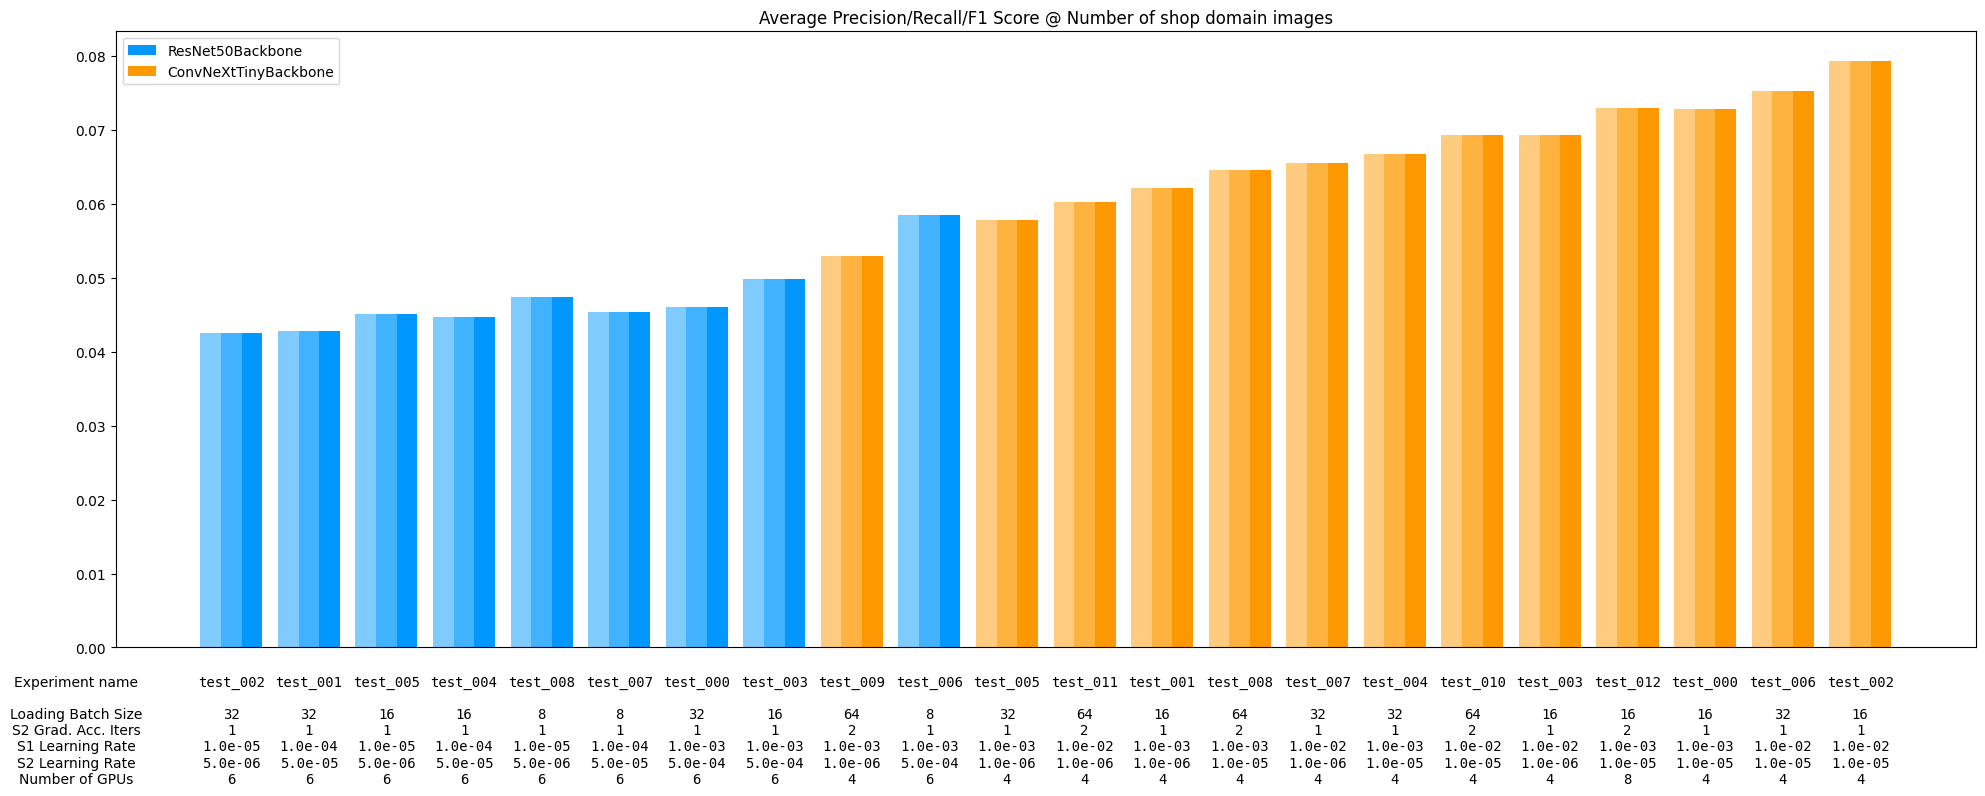

In [16]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_same"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_same"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_same"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @ Number of shop domain images")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}\n{:d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()

In [9]:
ord_df = df.sort_values("avg_test_f1_at_3", ascending=True)
ord_df = ord_df.reset_index(drop=True)

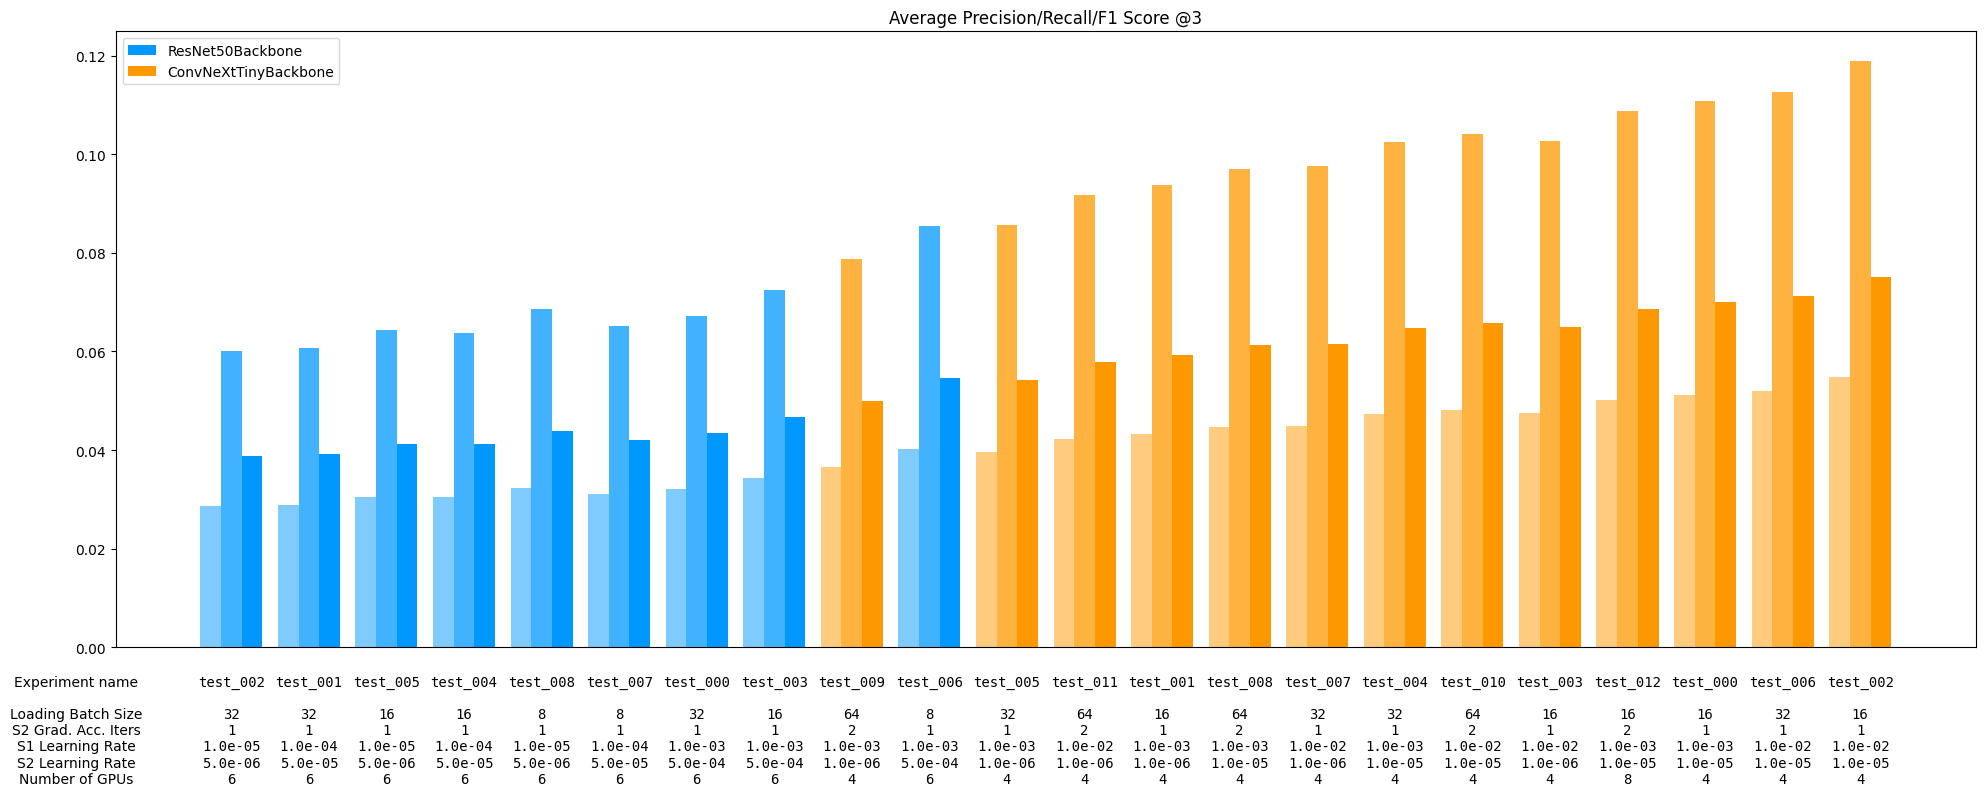

In [17]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_3"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_3"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_3"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @3")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}\n{:d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()

In [11]:
ord_df = df.sort_values("avg_test_f1_at_5", ascending=True)
ord_df = ord_df.reset_index(drop=True)

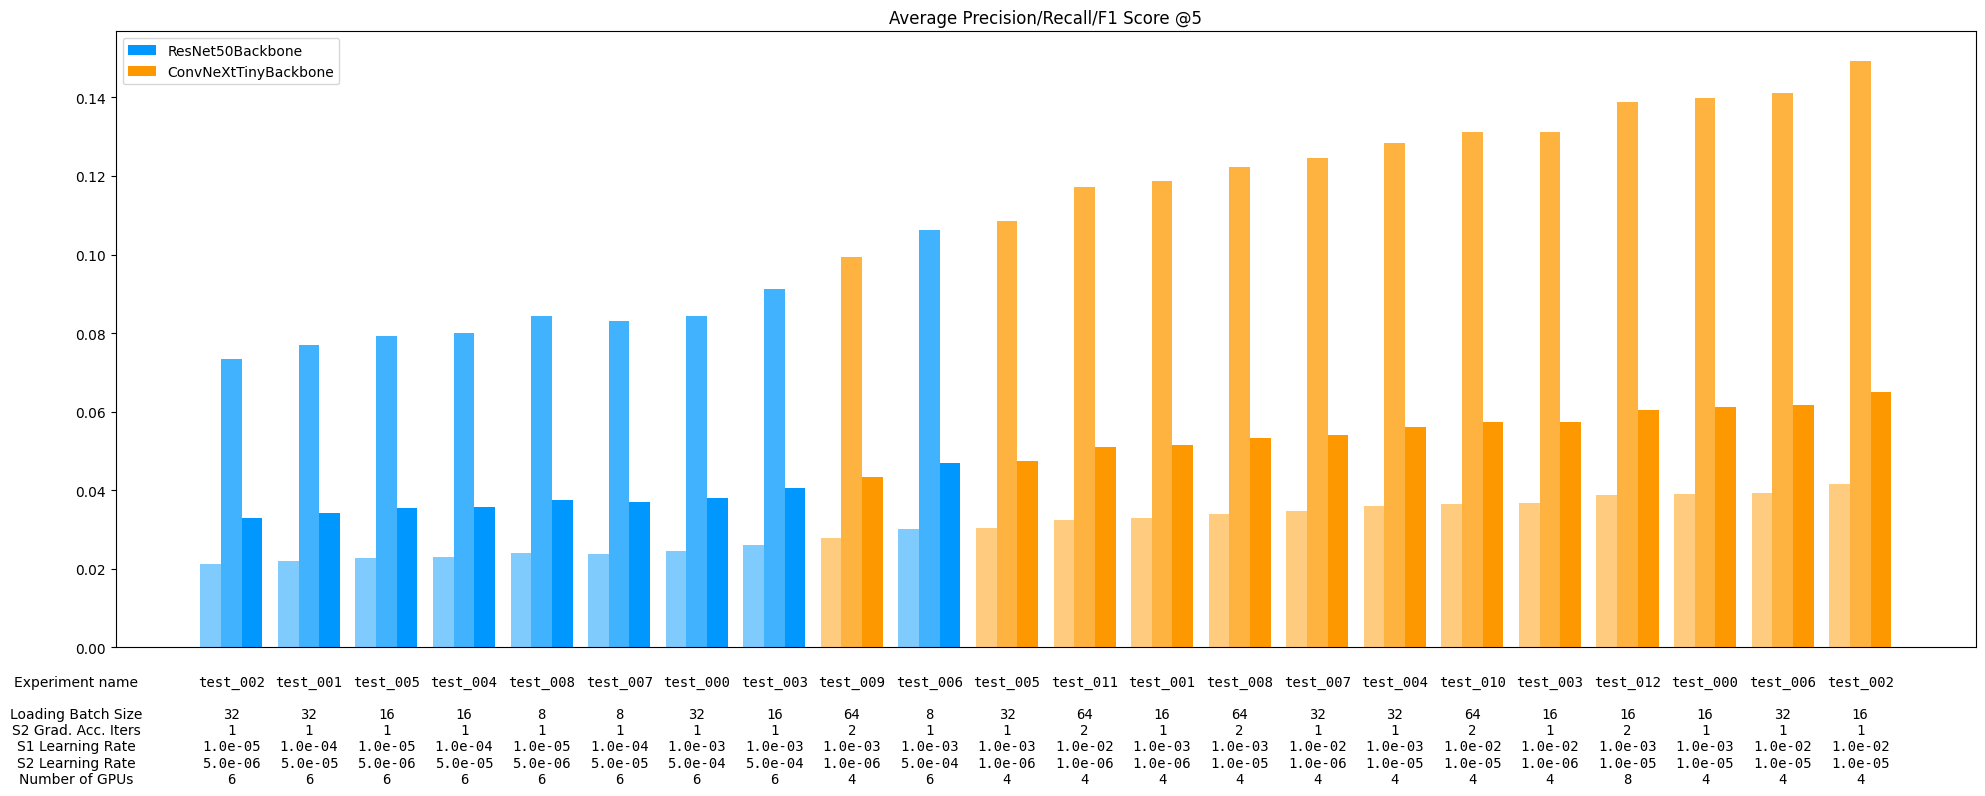

In [18]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_5"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_5"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_5"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @5")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}\n{:d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()

In [13]:
ord_df = df.sort_values("avg_test_f1_at_10", ascending=True)
ord_df = ord_df.reset_index(drop=True)

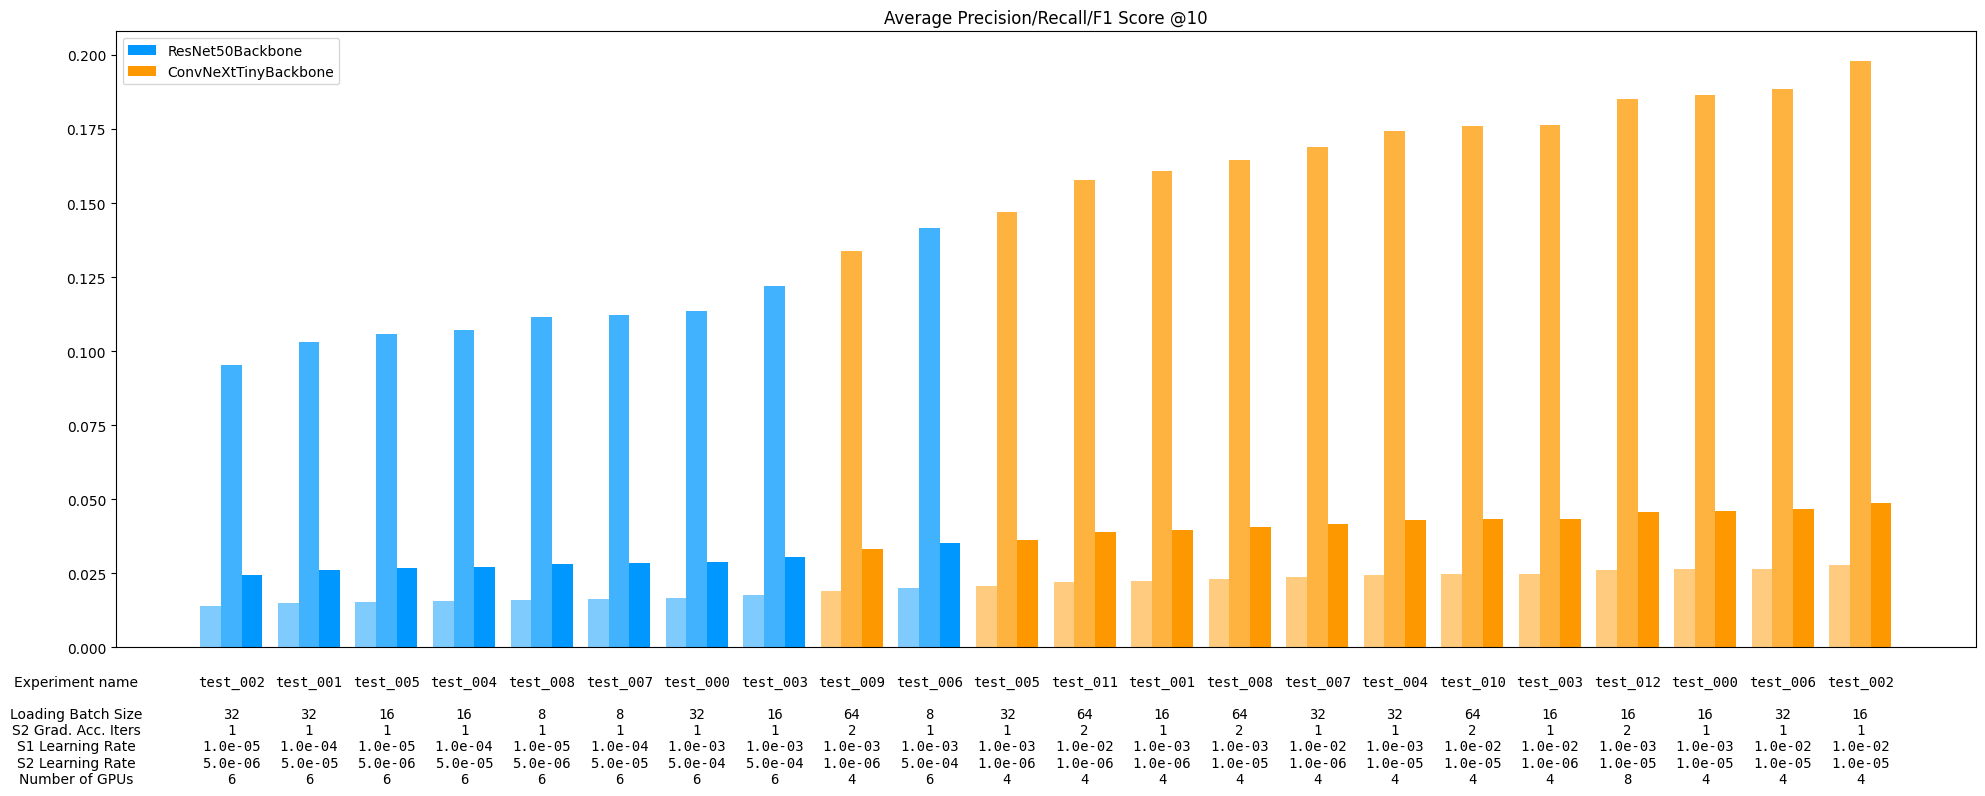

In [19]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([51/256, 153/256, 51/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([255/256, 153/256, 0/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_10"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_10"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_10"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @10")

###

text_height = - plt.ylim()[1] * 0.22

text = "{:s}\n\n{:s}\n{:s}\n{:s}\n{:s}\n{:s}".format(
    "Experiment name",
    "Loading Batch Size",
    "S2 Grad. Acc. Iters",
    "S1 Learning Rate",
    "S2 Learning Rate",
    "Number of GPUs"
)
plt.text(-2, text_height, text, ha="center")

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    for idx in ord_df_filt.index:
        text = "{:s}\n\n{:d}\n{:d}\n{:.1e}\n{:.1e}\n{:d}".format(
            ord_df_filt.at[idx, "experiment_name"],
            ord_df_filt.at[idx, "loading_batch_size"],
            ord_df_filt.at[idx, "stage_2_grad_acc_iters"],
            ord_df_filt.at[idx, "stage_1_lr"],
            ord_df_filt.at[idx, "stage_2_lr"],
            ord_df_filt.at[idx, "num_gpus"]
        )
        plt.text(idx, text_height, text, ha="center", family="monospace")
        
###

plt.show()